# CropArray example

---

## Notebook summary 


- Load a microscope image o video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Visualization with Napari

----

## Importing libraries


----

In [12]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
from rsnaped import rsnaped as rsp
ca.print_banner()
# %matplotlib inline 
#plt.style.use('default')

 
CropArray by : Luis Aguilera, and, Tim Stasevich 

░█████╗░██████╗░░█████╗░██████╗░░█████╗░██████╗░██████╗░░█████╗░██╗░░░██╗
██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗╚██╗░██╔╝
██║░░╚═╝██████╔╝██║░░██║██████╔╝███████║██████╔╝██████╔╝███████║░╚████╔╝░
██║░░██╗██╔══██╗██║░░██║██╔═══╝░██╔══██║██╔══██╗██╔══██╗██╔══██║░░╚██╔╝░░
╚█████╔╝██║░░██║╚█████╔╝██║░░░░░██║░░██║██║░░██║██║░░██║██║░░██║░░░██║░░░
░╚════╝░╚═╝░░╚═╝░╚════╝░╚═╝░░░░░╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝░░░╚═╝░░░




In [2]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "None",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

## Parameters for quantification


----

In [3]:
# parameters
particle_diameter= 7 #(3, 7, 7)   # Spot diameter :  z,y,x size of the spot      
tracking_channel = 0          # Channel  used for tracking
min_trajectory_length = 5    # Minimal number of frames to be consider as a trajectory
max_distance_movement = particle_diameter*2
# selecting time and z for visualization
selected_time = 4 
selected_z = 3 
# Visualization. Static image taking a given time point. Plotting the maximum projection in Z for a given channel.
selected_channel = 0
drop_size = 3

# Bead Alignment


----

In [4]:
# Loading image with beads
img_beads_path = current_dir.parents[0].joinpath('database','Gabriel_HT_example','beads05.tif')  
img_beads = imread(str(img_beads_path))  # (f, z, y, x, ch)
print(img_beads.shape)

(2, 512, 512)


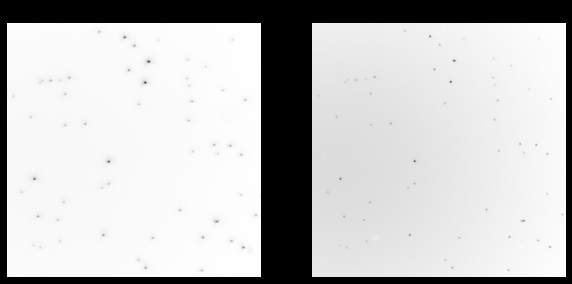

In [5]:
# plotting original image
# Just examining one of the images
num_channels = img_beads.shape[0] #3
fig, ax = plt.subplots(nrows=1, ncols=num_channels,figsize=(10,5))
for i in range(0,num_channels):
    ax[i].imshow(img_beads[i,...],cmap='gray_r' )
    ax[i].grid(False)
    ax[i].set_axis_off()
    ax[i].set_title('Channel_'+str(i))

In [15]:
homography_matrix = rsp.BeadsAlignment(img_beads,spot_size=5,min_intensity=100).make_beads_alignment()

The number of spots detected for the red channel are:
(22, 2)
The number of spots detected for the green channel are:
(22, 2)

The homography matrix is:
<ProjectiveTransform(matrix=
    [[ 1.00293101e+00,  4.80471006e-03,  2.81841858e-02],
     [-2.84368321e-03,  1.00663031e+00, -1.58752514e+00],
     [ 2.00182592e-06,  2.93645240e-06,  1.00000000e+00]])>


# Loading movie


----

In [24]:
img_file_path = current_dir.parents[0].joinpath('database','Gabriel_HT_example','MAX_bactin_Cell04_Good_int8.tif')  
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
img = imread(str(img_file_path))  # (f, z, y, x, ch)
img= np.moveaxis(img,1,3)
img= np.expand_dims(img,axis=1) 
img_croparray = np.expand_dims(img,axis=0) 
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)

img.shape

(60, 1, 512, 512, 2)

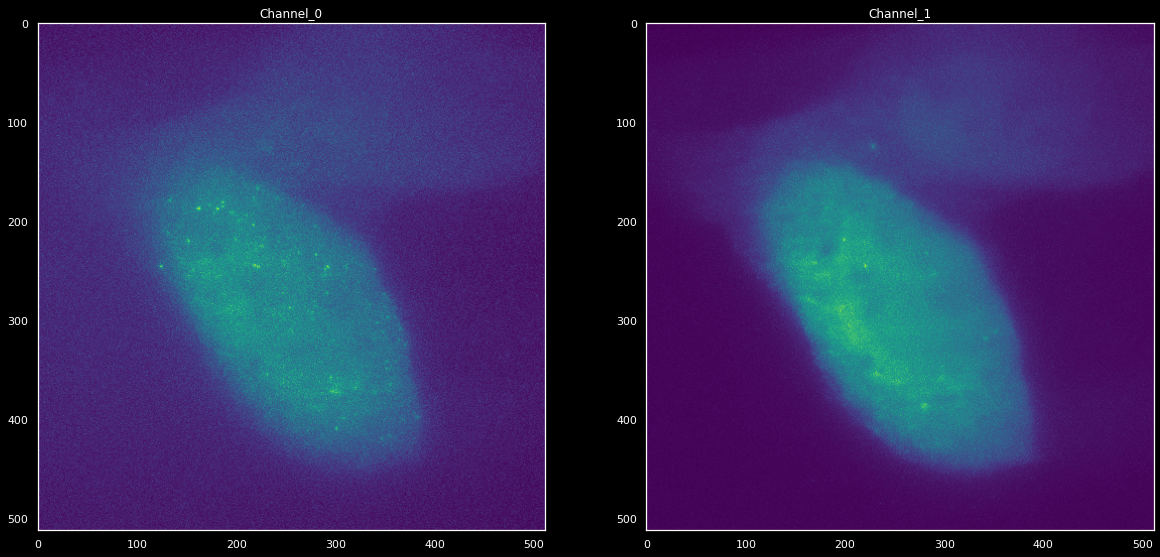

In [25]:
# plotting original image
# Just examining one of the images
num_channels = img_croparray.shape[5] #3
fig, ax = plt.subplots(nrows=1, ncols=num_channels,figsize=(20,10))
for i in range(0,num_channels):
    ax[i].imshow(np.max(img_croparray[0,selected_time,:,:,:,i] ,axis=0),cmap='viridis' )
    ax[i].grid(False)
    ax[i].set_title('Channel_'+str(i))

## Spot detection and tracking


----

In [ ]:
img_2D = np.amax(img_croparray[0,:,:,:,:,tracking_channel],axis=1)   #(fov, f , z, y, x, ch)
img_2D.shape # ( f, y, x)

In [ ]:
spots_df = ca.tracking_spots(img_2D,particle_diameter=particle_diameter,max_distance_movement=max_distance_movement,
                                    min_trajectory_length=min_trajectory_length, num_iterations = 100,show_plots=True)

## Creating CropArray


----

In [ ]:
my_ca = ca.create_crop_array(img_croparray,spots_df,xy_pad=3)   # homography
my_ca.coords

In [ ]:
# Plot one of the crops over time to test
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
best_z.where(my_ca.id==5).mean('n').sel(fov=0).plot.imshow(col='t',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5)

In [ ]:
# Create best-z projection using channel 1 (translation) as a reference. taking bestz +/- 1 here (roll_n = 3)
best_z = ca.best_z_proj(my_ca, ref_ch=1, disk_r=3, roll_n=3)
best_z = my_ca.int.sel(fov=0).max('z')
best_z.coords

In [ ]:
# view the action of montage
my_ca_montage= ca.montage(best_z, row = 't', col = 'n')
print(my_ca_montage.dims)
print(my_ca_montage.coords)

In [ ]:
montage_val  = my_ca_montage.sel(ch=0).values

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(montage_val)
plt.xlabel('n', size=10)
plt.ylabel('t', size=10)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
raise

In [ ]:
# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot
viewer = napari.Viewer()

In [ ]:
# view the action of montage [rows= time, columns = spot number]
viewer.add_image(my_ca_montage.sel(ch=1), colormap = 'green', name = 'green', blending = 'additive', contrast_limits=[0,my_ca_montage.sel(ch=1).data.max()])
viewer.add_image(my_ca_montage.sel(ch=0), colormap = 'red', name = 'red', blending='additive', contrast_limits=[0,my_ca_montage.sel(ch=0).data.max()])
viewer.add_image(my_ca_montage.sel(ch=2), colormap = 'blue', name = 'blue', blending='additive', contrast_limits=[0,my_ca_montage.sel(ch=2).data.max()])
nbscreenshot(viewer)